In [1]:
import os
from dotenv import load_dotenv
from PIL import Image

load_dotenv()

True

In [2]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import TextMentionTermination
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image as AGImage
from autogen_core import CancellationToken # 비동기 처리에서 지연 상황을 처리하기 위해 사용


In [3]:
model_client=OpenAIChatCompletionClient(
    model="gemini-2.0-flash",
    api_key = os.getenv("GOOGLE_API_KEY"),
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

## 에이전트 정의
![](flow.png)

### Main Assistant Agent
역할: 사용자와 문제상담을 소통하는 에이전트

주요 기능:
- 전문가들의 분석 내용을 이해하기 쉽게 요약
- 전문 용어를 일상적인 언어로 설명
- 사용자의 추가 질문에 친절하게 답변

In [4]:
main_assistant_agent = AssistantAgent(
    name="main_assistant_agent",
    model_client=model_client,
    system_message="""당신은 차량 문제에 대해 사용자와 소통하는 전문 상담가입니다.

핵심 역할:
1. 전문가들의 분석 내용을 사용자가 이해하기 쉽게 요약
2. 전문적인 용어를 일상적인 언어로 설명
3. 사용자의 추가 질문에 친절하게 답변

응답 원칙:
1. 간단명료하게 설명
2. 위험한 상황은 특히 강조
3. 불확실한 내용은 솔직히 인정
4. 모든 설명은 한국어로 제공

당신의 목표는 사용자가 현재 차량 상태와 필요한 조치를 쉽게 이해할 수 있도록 돕는 것입니다."""
)

### Vision Expert Agent
역할: 계기판 이미지 분석 전문가

주요 기능:
- 경고등 식별 및 상태 파악
- 게이지 수치 판독
- 이미지 품질 평가

분석 항목:
- 경고등 상태 (켜짐/꺼짐/깜빡임)
- 경고등 색상 (적색/황색/녹색)
- 게이지 수치 (속도/RPM/연료/온도)

In [5]:
vision_expert = AssistantAgent(
    name="vision_expert",
    model_client=model_client,
    system_message="""당신은 차량 계기판 이미지 분석 전문가입니다.

주요 책임:
1. 계기판 이미지에서 모든 경고등과 게이지를 식별하고 분석
2. 각 경고등의 상태(켜짐/꺼짐/깜빡임)와 색상을 정확히 파악
3. 게이지 수치(속도, RPM, 연료 등)를 정확히 읽고 해석

응답 형식:
[경고등 상태]
- 경고등 이름: [색상] [상태]
- 위치: [계기판 상의 위치]
- 표시 형태: [아이콘 설명]

[게이지 수치]
- 속도계: [수치] km/h
- RPM: [수치] x1000
- 연료계: [수치]%
- 온도계: [수치]°C

주의사항:
1. 불확실한 경우 "불확실"로 표시
2. 이미지 품질 문제 있을 경우 명시
3. 가려진 부분 있을 경우 언급
4. 경고등 색상은 반드시 명시 (적색/황색/녹색)"""
)


### Diagnostic Expert Agent
역할: 차량 문제 진단 전문가

주요 기능:
- 경고등 조합 분석
- 문제 심각도 평가
- 연관성 분석
- 잠재 위험 예측

진단 항목:
- 전체 상황 심각도 (상/중/하)
- 개별 문제 심각도
- 문제 간 연관성
- 운행 가능 여부 판단

In [6]:
diagnostic_expert = AssistantAgent(
    name="diagnostic_expert",
    model_client=model_client,
    system_message="""당신은 차량 문제 진단 전문가입니다.

주요 책임:
1. Vision Expert가 식별한 경고등 정보를 바탕으로 종합 진단
2. 각 문제의 심각도와 우선순위 평가
3. 문제들 간의 연관성 분석
4. 잠재적 위험 예측

응답 형식:
[심각도 평가]
- 전체 상황: [상/중/하]
- 개별 문제 심각도:
  * [경고등1]: [심각도] - [이유]
  * [경고등2]: [심각도] - [이유]

[원인 분석]
- 주요 원인: [설명]
- 연관 문제: [있는 경우 기술]
- 잠재적 위험: [예상되는 추가 문제]

[운행 가능 여부]
- 즉시 정차 필요: [예/아니오]
- 제한적 운행: [가능/불가능]
- 예상 안전 운행 거리: [추정치]"""
)

### Solution Expert Agent
역할: 차량 문제 해결 전문가

주요 기능:
- 상황별 해결책 제시
- 행동 지침 제공
- 비용/시간 추정
- 긴급 대처 방안 제시

제공 정보:
- 즉각적 조치사항
- 단/중/장기 해결방안
- 예상 수리 비용
- 정비 소요 시간

In [7]:
solution_expert = AssistantAgent(
    name="solution_expert",
    model_client=model_client,
    system_message="""당신은 차량 문제 해결 전문가입니다.

주요 책임:
1. Diagnostic Expert의 진단을 바탕으로 최적의 해결책 제시
2. 상황별 구체적 행동 지침 제공
3. 정비 필요성 및 예상 비용 산정
4. 긴급 상황 대처 방안 제시

응답 형식:
[즉각 조치사항]
- 운전자 행동 지침: [구체적 행동 단계]
- 긴급 연락처: [필요한 경우]
- 안전 주의사항: [구체적 주의점]

[해결 방안]
- 단기 조치: [즉시 필요한 조치]
- 중기 조치: [며칠 내 필요한 조치]
- 장기 조치: [향후 예방을 위한 조치]

[비용 추정]
- 예상 수리 비용: [범위]
- 정비 소요 시간: [추정치]
- 대체 교통수단: [필요한 경우]"""
)

In [8]:
## 에이전트 간 상호작용 구현

In [9]:
async def process_dashboard_image(image, user_query):
    # 1. 메인 어시스턴트가 초기 질문 접수하고 Vision Expert에게 전달
    initial_message = MultiModalMessage(
        content=[user_query, image],
        source="User"
    )
    
    # Vision Expert 분석
    vision_response = await vision_expert.on_messages(
        [initial_message],
        cancellation_token=CancellationToken()
    )
    
    # 2. Vision Expert의 결과를 Diagnostic Expert에게 전달
    diagnostic_message = MultiModalMessage(
        content=[vision_response.chat_message.content, image],
        source="VisionExpert"
    )
    diagnostic_response = await diagnostic_expert.on_messages(
        [diagnostic_message],
        cancellation_token=CancellationToken()
    )
    
    # 3. Diagnostic Expert의 결과를 Solution Expert에게 전달
    solution_message = MultiModalMessage(
        content=[diagnostic_response.chat_message.content],
        source="DiagnosticExpert"
    )
    solution_response = await solution_expert.on_messages(
        [solution_message],
        cancellation_token=CancellationToken()
    )
    
    # 4. 모든 분석 결과를 메인 어시스턴트에게 전달하여 최종 응답 생성
    final_message = MultiModalMessage(
        content=[
            initial_message.content[0],  # 원래 사용자 질문
            vision_response.chat_message.content,
            diagnostic_response.chat_message.content,
            solution_response.chat_message.content
        ],
        source="System"
    )
    
    final_response = await main_assistant_agent.on_messages(
        [final_message],
        cancellation_token=CancellationToken()
    )
    
    # return final_response.chat_message.content

    # debug
    return {
        'final_response': final_response,
        'vision_analysis': vision_response,
        'diagnostic_analysis': diagnostic_response,
        'solution_analysis': solution_response
    }

## 사용 예시


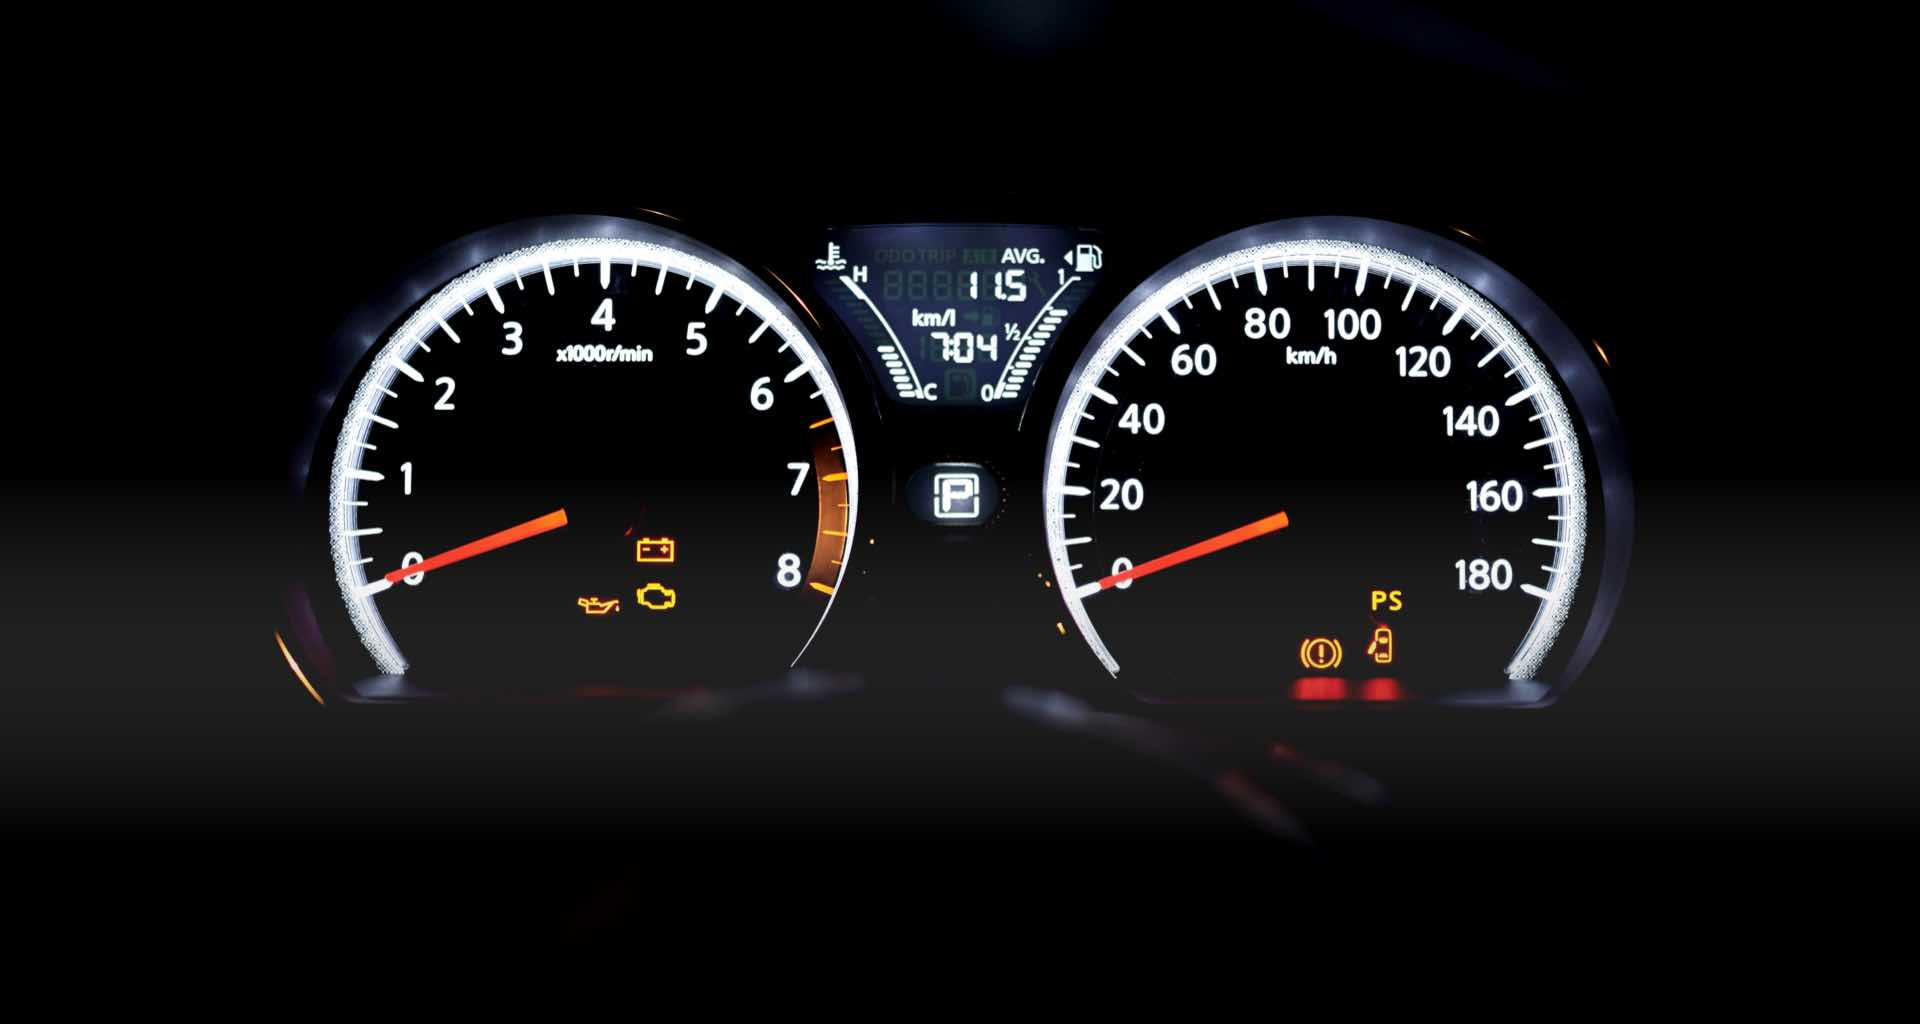

In [10]:
# 계기판 이미지 로드
current_dir = os.getcwd()
image_path = os.path.abspath(os.path.join("samples", "sample1.jpg"))

pil_image = Image.open(image_path)
img = AGImage(pil_image)
img

In [11]:
user_message = "지금 경고등이 떴어 무슨 상황이야?"
multi_modal_message = MultiModalMessage(content=[user_message, img], source="User")

# 질문 전달
response = await process_dashboard_image(img, user_message)

print("사용자 메시지: {}".format(multi_modal_message.content))

사용자 메시지: ['지금 경고등이 떴어 무슨 상황이야?', <autogen_core._image.Image object at 0x107c43bf0>]


In [12]:
print("비전 분석: {}".format(response['vision_analysis'].chat_message.content))

비전 분석: [경고등 상태]
- 배터리 경고등: [황색] [켜짐]
- 위치: [좌측 하단]
- 표시 형태: 배터리 모양 아이콘

- 엔진오일 경고등: [황색] [켜짐]
- 위치: [좌측 하단]
- 표시 형태: 오일 펌프 모양 아이콘

- 브레이크 경고등: [적색] [켜짐]
- 위치: [우측 하단]
- 표시 형태: 원 안에 느낌표가 있는 아이콘

- 파워 스티어링 경고등: [적색] [켜짐]
- 위치: [우측 하단]
- 표시 형태: 핸들 모양 아이콘

[게이지 수치]
- 속도계: 15 km/h
- RPM: 1 x1000
- 연료계: Full
- 온도계: Low


In [13]:
print("진단 분석: {}".format(response['diagnostic_analysis'].chat_message.content))

진단 분석: ## 진단 결과

**[심각도 평가]**
- 전체 상황: **상**
- 개별 문제 심각도:
  * 배터리 경고등: **중** - 발전기 문제 또는 배터리 자체의 문제 가능성
  * 엔진오일 경고등: **중** - 엔진오일 압력 부족 또는 오일 부족
  * 브레이크 경고등: **상** - 브레이크액 부족, 브레이크 시스템 고장 또는 주차 브레이크 작동
  * 파워 스티어링 경고등: **상** - 파워 스티어링 시스템 고장

**[원인 분석]**
- 주요 원인: 여러 경고등이 동시에 점등된 것은 **전반적인 전기 시스템 문제** 또는 **엔진 구동 문제**로 인해 발생했을 가능성이 높습니다. 각 경고등은 독립적인 문제일 수도 있지만, 하나의 근본적인 원인에서 비롯되었을 가능성을 고려해야 합니다.
- 연관 문제: 엔진오일 경고등과 파워 스티어링 경고등은 엔진 작동과 직접적인 관련이 있으므로, 엔진 자체의 문제 또는 엔진에 전력을 공급하는 시스템의 문제일 수 있습니다.
- 잠재적 위험:
    * 브레이크 시스템 고장은 **제동력 상실**로 이어져 매우 위험한 상황을 초래할 수 있습니다.
    * 파워 스티어링 고장은 **핸들 조작을 어렵게** 만들어 사고 위험을 증가시킵니다.
    * 배터리 문제는 **엔진 시동 불능** 또는 **주행 중 차량 멈춤**을 유발할 수 있습니다.

**[운행 가능 여부]**
- 즉시 정차 필요: **예**
- 제한적 운행: **불가능**
- 예상 안전 운행 거리: **0 km** (즉시 점검 필요)

**추가 조치:**

1.  **즉시 안전한 곳에 정차하십시오.**
2.  **전문 정비사에게 연락하여 차량 상태를 점검받으십시오.** 여러 경고등이 동시에 켜진 경우, 자가 진단보다는 전문가의 진단이 필요합니다.
3.  점검 시 전기 시스템, 엔진오일 레벨 및 압력, 브레이크 시스템, 파워 스티어링 시스템을 모두 확인하십시오.

**주의:** 위에 제시된 내용은 제한된 정보에 기반한 추정일 뿐이며, 실제 차량 상태와는 다

In [14]:
print("해결 분석: {}".format(response['solution_analysis'].chat_message.content))

해결 분석: ## 여러 경고등 점등에 따른 문제 해결 방안

**[즉각 조치사항]**

*   **운전자 행동 지침:**

    1.  **안전한 장소로 즉시 이동:** 갓길이나 주차장 등 안전한 곳에 차를 세우십시오. 교통 흐름을 방해하지 않고, 추가 사고 위험이 없는 곳을 선택해야 합니다.
    2.  **엔진 정지:** 차량을 완전히 정지시킨 후 엔진을 끄십시오. 추가적인 손상을 막기 위해 엔진을 멈추는 것이 중요합니다.
    3.  **비상등 작동:** 비상등을 켜서 다른 운전자들에게 차량에 문제가 있음을 알리십시오.
    4.  **안전 확보:** 차량에서 내릴 때는 주변을 살피고 안전 조끼를 착용하십시오. 다른 차량의 움직임을 주시하며 안전하게 행동하십시오.
    5.  **추가 시도 금지:** 엔진을 다시 켜거나 다른 시스템을 작동시키지 마십시오. 추가적인 손상을 유발할 수 있습니다.
*   **긴급 연락처:**

    *   보험사 긴급출동 서비스: (보험사 연락처)
    *   가까운 정비소: (정비소 연락처)
    *   견인 서비스: (견인 업체 연락처)
*   **안전 주의사항:**
    *   절대 무리하게 운전하지 마십시오.
    *   다른 차량에게 잘 보이는 위치에 삼각대를 설치하십시오.
    *   차량 주변에서 안전을 유지하고, 다른 차량의 움직임에 주의하십시오.

**[해결 방안]**

*   **단기 조치:**

    1.  **정비소 연락 및 견인:** 가장 가까운 정비소에 연락하여 상황을 설명하고 차량을 견인합니다. 여러 경고등이 동시에 점등된 상황은 전문가의 진단이 필요합니다.
    2.  **정비소 방문 상담:** 정비사와 함께 문제의 원인을 파악하고, 필요한 수리 범위를 결정합니다. 진단 결과를 꼼꼼히 확인하고, 수리 계획을 세웁니다.
*   **중기 조치:**

    1.  **정밀 진단:** 정비소에서 전기 시스템, 엔진오일 시스템, 브레이크 시스템, 파워 스티어링 시스템에 대한 정밀 진

In [15]:
print("최종 응답: {}".format(response['final_response'].chat_message.content))

최종 응답: 알겠습니다. 지금 차량에 여러 경고등이 동시에 뜬 상황은 꽤 심각해 보입니다. 마치 몸에 여러 군데 동시에 빨간불이 켜진 것과 같아요.

**핵심은 "즉시 안전한 곳에 차를 세우고 전문가의 도움을 받는 것"입니다.**

**쉽게 풀어 설명하자면:**

*   **배터리 경고등 (노란색):** "배터리가 충전이 잘 안 되고 있어!"라고 말하는 거예요. 발전기 문제일 수도 있고, 배터리 자체가 약해졌을 수도 있어요.
*   **엔진오일 경고등 (노란색):** "엔진에 오일이 충분히 공급되지 않고 있어!"라는 뜻입니다. 엔진오일이 부족하거나 오일펌프에 문제가 있을 수 있어요.
*   **브레이크 경고등 (빨간색):** "브레이크에 문제가 생겼어! 당장 멈춰야 해!"라는 아주 위험한 신호입니다. 브레이크액이 부족하거나 브레이크 시스템 자체에 고장이 생겼을 가능성이 높아요.
*   **파워 스티어링 경고등 (빨간색):** "핸들이 평소보다 무거워질 수 있어!"라는 경고입니다. 핸들을 돌리는 데 필요한 유압이나 전기 시스템에 문제가 생긴 거예요.

**왜 위험할까요?**

*   **브레이크 문제:** 브레이크가 제대로 작동하지 않으면 큰 사고로 이어질 수 있습니다.
*   **파워 스티어링 문제:** 갑자기 핸들이 무거워지면 운전하기가 매우 어려워집니다.
*   **배터리 문제:** 시동이 꺼지거나 주행 중에 차가 멈출 수 있습니다.
*   **엔진오일 문제:** 엔진이 망가질 수 있습니다.

**지금 당장 해야 할 일:**

1.  **안전한 곳에 즉시 정차:** 갓길이나 주차장처럼 안전한 곳에 차를 세우세요.
2.  **정비소에 연락:** 가까운 정비소나 긴급출동 서비스에 전화해서 상황을 설명하고 도움을 요청하세요.
3.  **차를 움직이지 마세요:** 괜히 더 큰 문제가 생길 수 있으니, 전문가가 와서 점검하기 전까지는 차를 움직이지 않는 것이 좋습니다.

**궁금한 점이 있다면 언제든지 다시 물어보세요. 안전이 최우선입니다!**

